In [1]:
import cv2
import IPython.display 
import importlib
import skimage.io as imgio
import numpy as np
import os
import torch
from graph_routines import graph_from_3D_mask, detectAndRemoveClusters, cycleBasis, reduceCycleBasis, minCycleBasis, verifyEdges
import scipy.sparse.csgraph as g
from skimage.morphology import skeletonize_3d
import pickle

def imshow(img):
    _,ret = cv2.imencode('.jpg', img) 
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)
    
def showCube(vol):
    v1=np.max(vol,axis=0)
    v2=np.max(vol,axis=1)
    v3=np.max(vol,axis=2)
    imshow(v1*255)
    imshow(v2*255)
    imshow(v3*255)
def show2Cubes(vol1,vol2):
    v11=np.max(vol1,axis=0)
    v12=np.max(vol1,axis=1)
    v13=np.max(vol1,axis=2)
    v21=np.max(vol2,axis=0)
    v22=np.max(vol2,axis=1)
    v23=np.max(vol2,axis=2)
    imshow(np.concatenate([v11,v21],1)*255)
    imshow(np.concatenate([v12,v22],1)*255)
    imshow(np.concatenate([v13,v23],1)*255)
    
def show3Cubes(vol1,vol2,vol3):
    v11=np.max(vol1,axis=0)
    v12=np.max(vol1,axis=1)
    v13=np.max(vol1,axis=2)
    v21=np.max(vol2,axis=0)
    v22=np.max(vol2,axis=1)
    v23=np.max(vol2,axis=2)
    v31=np.max(vol3,axis=0)
    v32=np.max(vol3,axis=1)
    v33=np.max(vol3,axis=2)
    imshow(np.concatenate([v11,v21,v31],1)*255)
    imshow(np.concatenate([v12,v22,v32],1)*255)
    imshow(np.concatenate([v13,v23,v33],1)*255)
    
def show4Cubes(vol1,vol2,vol3,vol4):
    v11=np.max(vol1,axis=0)
    v12=np.max(vol1,axis=1)
    v13=np.max(vol1,axis=2)
    v21=np.max(vol2,axis=0)
    v22=np.max(vol2,axis=1)
    v23=np.max(vol2,axis=2)
    v31=np.max(vol3,axis=0)
    v32=np.max(vol3,axis=1)
    v33=np.max(vol3,axis=2)
    v41=np.max(vol4,axis=0)
    v42=np.max(vol4,axis=1)
    v43=np.max(vol4,axis=2)
    imshow(np.concatenate([v11,v21,v31,v41],1)*255)
    imshow(np.concatenate([v12,v22,v32,v42],1)*255)
    imshow(np.concatenate([v13,v23,v33,v43],1)*255)

In [2]:
from graph_routines import detectAndRemoveClusters, cycleBasis, reduceCycleBasis, minCycleBasis, verifyEdges

In [3]:
imgdir="/cvlabdata2/home/kozinski/experimentsTorch/mra/data_npy/img/train"
lbldir="/cvlabdata2/home/kozinski/experimentsTorch/mra/data_npy/lbl_margin/train"
testimgdir="/cvlabdata2/home/kozinski/experimentsTorch/mra/data_npy/img/test"
testlbldir="/cvlabdata2/home/kozinski/experimentsTorch/mra/data_npy/lbl_margin/test"
exec(open("testFiles_mra.txt").read())
exec(open("trainFiles_mra.txt").read())

gdir="/cvlabdata2/home/kozinski/experimentsTorch/MRAdata/lbl_graph_npy/"

In [4]:
datadir="/cvlabdata2/home/kozinski/experimentsTorch/mra/data_npy/"
graphdir=os.path.join(datadir,"lbl_graph")
#os.mkdir(graphdir)
traingraphdir=os.path.join(graphdir,"train")
#os.mkdir(traingraphdir)
testgraphdir=os.path.join(graphdir,"test")
#os.mkdir(testgraphdir)

In [5]:

def removeCycle(edges,cycle):
    nodes_cycle=np.nonzero(cycle.reshape(edges.shape))[0]
    for k in nodes_cycle:
        if edges[k].sum()<3: # not connected to the outside of the cycle
            return k,True
    return 0,False

def removeCycles(edges,cycles):
    nodes= np.array(range(edges.shape[0]))
    nodes_to_be_removed=[]
    succ = True
    for c in cycles:
        if c.sum()<5:
            print("attempting to remove cycle length",c.sum())
            n,res=removeCycle(edges,c)
            if res:
                print("succeeded")
            else:
                print("failed")
            succ=succ and res
            if res:
                nodes_to_be_removed.append(n)
        else:
            print("detected cycle lenght {} and nor removing it".format(c.sum()))
    edges=np.delete(edges,nodes_to_be_removed,axis=0)
    edges=np.delete(edges,nodes_to_be_removed,axis=1)
    nodes=np.delete(nodes,nodes_to_be_removed,axis=0)
    return edges,nodes,succ
            

In [6]:
# check for single dangling nodes
def checkDangling(edges):
    dangling=[]
    singlyConnected=np.nonzero(edges.sum(1)==1)[0]
    for k in singlyConnected:
        nb=np.argmax(edges[k]).item()
        if edges[nb].sum()>2:
            #print("dangling node")
            dangling.append(k)
    return np.array(dangling)

def removeDangling(edges,nodes):
    k=0
    while k<edges.shape[0]:
        if edges[k].sum()==1:
            # k is singly connected
            nb=np.argmax(edges[k]).item()
            if edges[nb].sum()>2:
                # the only neighbor of k is multiply connected
                # so k is a dangling node
                edges=np.delete(edges,(k),0)
                edges=np.delete(edges,(k),1)
                nodes=np.delete(nodes,(k),0)
                continue
        k=k+1
    return edges,nodes
        

In [14]:
# prepare graphs for training ground truths
graphs=[]
for f in trainFiles:
    print(f)
    img=np.load(os.path.join(imgdir,f[1])).astype(np.float32)
    lbl=np.load(os.path.join(lbldir,f[1])).astype(np.float32)
    #img=np.copy(img[:,0:100,100:200,100:200])
    #lbl=np.copy(lbl[0:100,100:200,100:200])
    lbl[lbl<2]=0
    lbl=lbl/2
    fedges=f[0][-7:-4]+'_edges.npy'
    fnodes=f[0][-7:-4]+'_nodeCoords.npy'
    e=np.load(os.path.join(gdir,fedges))
    nc=np.load(os.path.join(gdir,fnodes))
    #print(os.path.join(gdir,fnodes))
    #lbl_graph=renderGraph(lbl,nc)
    #show3Cubes(lbl,(lbl_graph),lbl_graph!=lbl)
    #break
    
    ff=open(os.path.join(traingraphdir,f[1]),"bw")
    gt={'edges':e,'node_coordinates':(nc-1).astype(np.int)}
    pickle.dump(gt,ff)
    ff.close()
    #break

['Normal-002.npy', 'Normal-002.npy']
['Normal-003.npy', 'Normal-003.npy']
['Normal-004.npy', 'Normal-004.npy']
['Normal-006.npy', 'Normal-006.npy']
['Normal-011.npy', 'Normal-011.npy']
['Normal-017.npy', 'Normal-017.npy']
['Normal-018.npy', 'Normal-018.npy']
['Normal-020.npy', 'Normal-020.npy']
['Normal-023.npy', 'Normal-023.npy']
['Normal-025.npy', 'Normal-025.npy']
['Normal-026.npy', 'Normal-026.npy']
['Normal-027.npy', 'Normal-027.npy']
['Normal-033.npy', 'Normal-033.npy']
['Normal-037.npy', 'Normal-037.npy']
['Normal-040.npy', 'Normal-040.npy']
['Normal-045.npy', 'Normal-045.npy']
['Normal-047.npy', 'Normal-047.npy']
['Normal-054.npy', 'Normal-054.npy']
['Normal-057.npy', 'Normal-057.npy']
['Normal-058.npy', 'Normal-058.npy']
['Normal-060.npy', 'Normal-060.npy']
['Normal-063.npy', 'Normal-063.npy']
['Normal-064.npy', 'Normal-064.npy']
['Normal-070.npy', 'Normal-070.npy']
['Normal-071.npy', 'Normal-071.npy']
['Normal-074.npy', 'Normal-074.npy']
['Normal-077.npy', 'Normal-077.npy']
[

In [8]:
# here you can check the graphs some more....

In [15]:
# prepare graphs for test ground truths
graphs=[]
for f in testFiles:
    print(f)
    img=np.load(os.path.join(testimgdir,f[1])).astype(np.float32)
    lbl=np.load(os.path.join(testlbldir,f[1])).astype(np.float32)
    #img=np.copy(img[:,0:100,0:100,0:100])
    #lbl=np.copy(lbl[0:100,0:100,0:100])
    lbl[lbl<2]=0
    lbl=lbl/2
    fedges=f[0][-7:-4]+'_edges.npy'
    fnodes=f[0][-7:-4]+'_nodeCoords.npy'
    e=np.load(os.path.join(gdir,fedges))
    nc=np.load(os.path.join(gdir,fnodes))
    ff=open(os.path.join(testgraphdir,f[1]),"bw")
    gt={'edges':e,'node_coordinates':(nc-1).astype(np.int)}
    pickle.dump(gt,ff)
    ff.close()

['Normal-008.npy', 'Normal-008.npy']
['Normal-009.npy', 'Normal-009.npy']
['Normal-010.npy', 'Normal-010.npy']
['Normal-012.npy', 'Normal-012.npy']
['Normal-021.npy', 'Normal-021.npy']
['Normal-022.npy', 'Normal-022.npy']
['Normal-034.npy', 'Normal-034.npy']
['Normal-042.npy', 'Normal-042.npy']
['Normal-043.npy', 'Normal-043.npy']
['Normal-044.npy', 'Normal-044.npy']
['Normal-056.npy', 'Normal-056.npy']


In [ ]:
# check the graphs...

/cvlabdata2/home/kozinski/experimentsTorch/mra/data_npy/lbl_margin/train
['Normal-002.npy', 'Normal-002.npy']


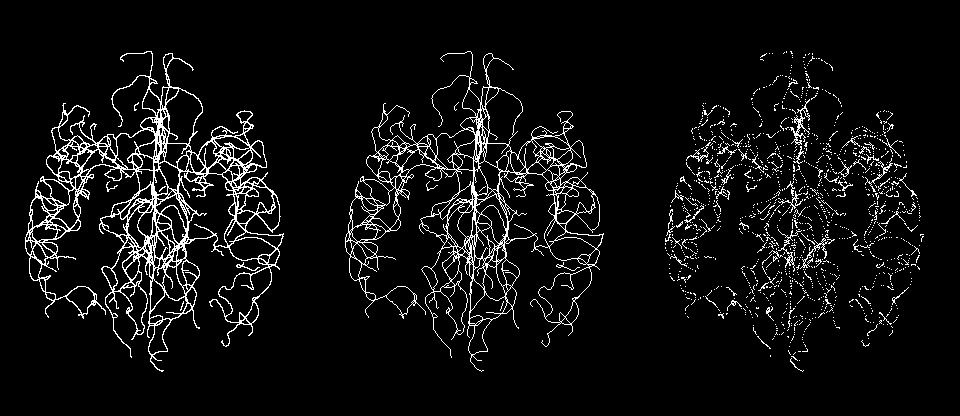

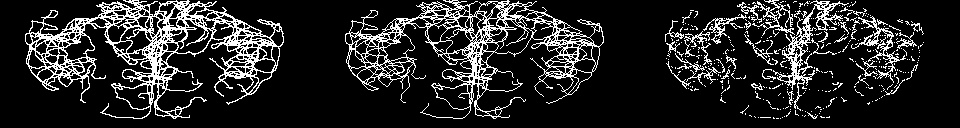

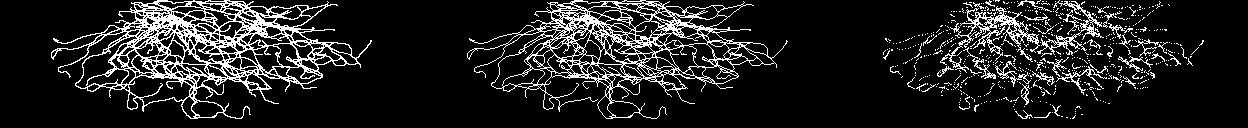

In [16]:
# verify the saved data: both test and train graphs
def renderGraph(lbl,coords):
    lbl_=np.zeros_like(lbl)
    for k in range(coords.shape[0]):
        lbl_[coords[k][0],coords[k][1],coords[k][2]]=1
    return lbl_

files=[trainFiles, testFiles]
lbldirs=[lbldir,testlbldir]
gdirs=[traingraphdir,testgraphdir]
for fls,lds,gd in zip(files,lbldirs,gdirs):
    print(lds)
    for f in fls:
        print(f)
        lbl=np.load(os.path.join(lds,f[1])).astype(np.float32)
        lbl[lbl<2]=0
        lbl=lbl/2
        #inds,edges,d2=graph_from_3D_mask(lbl)
        ff=open(os.path.join(gd,f[1]),"rb")
        gt=pickle.load(ff)
        ff.close()
        nc=gt['node_coordinates']
        edges_graph=gt['edges']
        #lbl_graph,n_graph=colorComponents(lbl,edges_graph,nc)
        #lbl_color,n_orig=colorComponents(lbl,edges,inds)
        lbl_graph=renderGraph(lbl,nc+np.array([[0,0,0]]))
        show3Cubes(lbl,(lbl_graph),lbl_graph!=lbl)
        #assert(n_graph==n_orig)
        break
    break